In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

from keras import layers
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.models import Model

        

2022-08-27 11:32:28.600345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-27 11:32:28.600378: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
NOISE_FACTOR = 0.5
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

np.random.seed = 20


def preproc(imgArr):
    imgArr = imgArr.astype("float32") / 255.0
    imgArr = np.reshape(imgArr, (len(imgArr), IMAGE_HEIGHT, IMAGE_WIDTH, 1))
    return imgArr

def addGaussianNoise(imgArr, noiseFactor):
    if noiseFactor < 0:
        raise Exception("Specify a positive noise factor")
    
    imgNoisyArr = imgArr + noiseFactor * np.random.normal(loc=0.0, scale=1, size=imgArr.shape)
    return np.clip(imgNoisyArr, 0.0, 1.0)

def showImgArrays(arr1, arr2, num, txt1 = "original", txt2 = "reconstructed"):
    if len(arr1) != len(arr2):
        raise Exception("Array 1 and array 2 must have the same length")
    if num > len(arr1):
        raise Exception("The number of elements to return must be lower than the array length")
    
    indexes = np.random.randint(len(arr1), size=num)
    imgArr1 = arr1[indexes, :]
    imgArr2 = arr2[indexes, :]
    
    plt.figure(figsize=(20, 4))
    for i, (img1, img2) in enumerate(zip(imgArr1, imgArr2)):
        ax = plt.subplot(2, num, i + 1)
        plt.imshow(img1.reshape(IMAGE_HEIGHT, IMAGE_WIDTH))
        plt.gray()
        plt.title(txt1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, num, i + 1 + num)
        plt.imshow(img2.reshape(IMAGE_HEIGHT, IMAGE_WIDTH))
        plt.gray()
        plt.title(txt2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

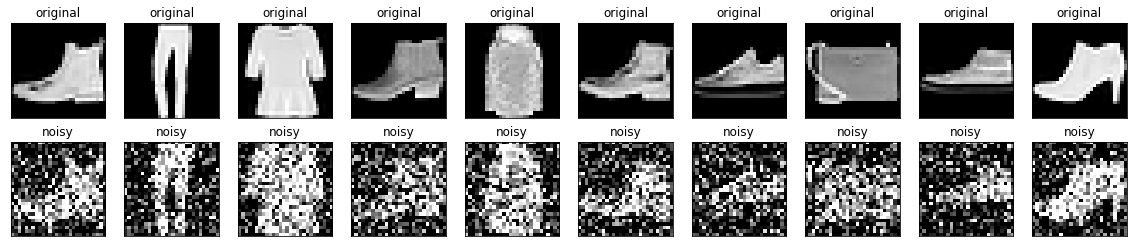

In [8]:
#(trainingSet, _), (testSet, _) = mnist.load_data()
(trainingSet, _), (testSet, _) = fashion_mnist.load_data()

# Normalize and reshape data
trainingSet = preproc(trainingSet)
testSet = preproc(testSet)

noisyTrainingSet = addGaussianNoise(trainingSet, noiseFactor=NOISE_FACTOR)
noisyTestSet = addGaussianNoise(testSet, noiseFactor=NOISE_FACTOR)

showImgArrays(trainingSet, noisyTrainingSet, 10, txt2 = "noisy")


2022-08-27 11:32:40.025226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-27 11:32:40.025289: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-27 11:32:40.025325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dosclic98-350V5C-351V5C-3540VC-3440VC): /proc/driver/nvidia/version does not exist


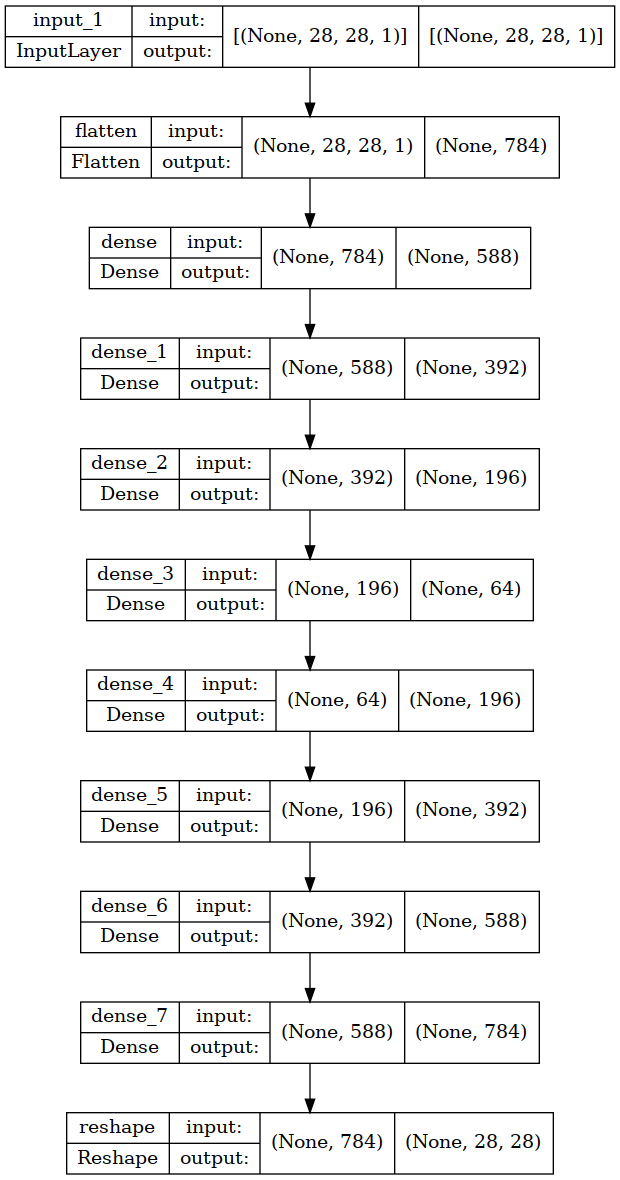

In [4]:
# Encoder
input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
e1 = layers.Flatten()(input)
e2 = layers.Dense(588, activation='relu')(e1)
e3 = layers.Dense(392, activation='relu')(e2)
e4 = layers.Dense(196, activation='relu')(e3)

# Encoded Layer
h5 = layers.Dense(64, activation='relu')(e4)

#Decoder
d6 = layers.Dense(196, activation='relu')(h5)
d7 = layers.Dense(392, activation='relu')(d6)
d8 = layers.Dense(588, activation='relu')(d7)
d9 = layers.Dense(784, activation='sigmoid')(d8)
d10 = layers.Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(d9)


# Autoencoder
autoencoder = Model(input, d10)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

plot_model(autoencoder, show_shapes=True)


In [5]:
autoencoder.fit(
    x=trainingSet,
    y=trainingSet,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(testSet, testSet),
)

2022-08-27 11:32:40.530001: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-08-27 11:32:40.652547: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/50
469/469 [==============================] - 15s 30ms/step - loss: 0.0322 - val_loss: 0.0198
Epoch 2/50
469/469 [==============================] - 14s 30ms/step - loss: 0.0176 - val_loss: 0.0161
Epoch 3/50
469/469 [==============================] - 16s 35ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 4/50
469/469 [==============================] - 17s 37ms/step - loss: 0.0136 - val_loss: 0.0139
Epoch 5/50
469/469 [==============================] - 20s 43ms/step - loss: 0.0126 - val_loss: 0.0123
Epoch 6/50
 18/469 [>.............................] - ETA: 17s - loss: 0.0119

KeyboardInterrupt: 

In [ ]:
predictions = autoencoder.predict(testSet)
showImgArrays(testSet, predictions, 10)

In [ ]:
# Save the model
autoencoder.save("modelAutoencoder.h5")

In [6]:
autoencoder.fit(
    x=noisyTrainingSet,
    y=trainingSet,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(noisyTestSet, testSet),
)

2022-08-27 11:34:30.252818: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/3
  3/469 [..............................] - ETA: 14s - loss: 0.0561

2022-08-27 11:34:30.581549: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


469/469 [==============================] - 15s 33ms/step - loss: 0.0202 - val_loss: 0.0262
Epoch 2/3
469/469 [==============================] - 19s 40ms/step - loss: 0.0171 - val_loss: 0.0253
Epoch 3/3
469/469 [==============================] - 19s 40ms/step - loss: 0.0164 - val_loss: 0.0235


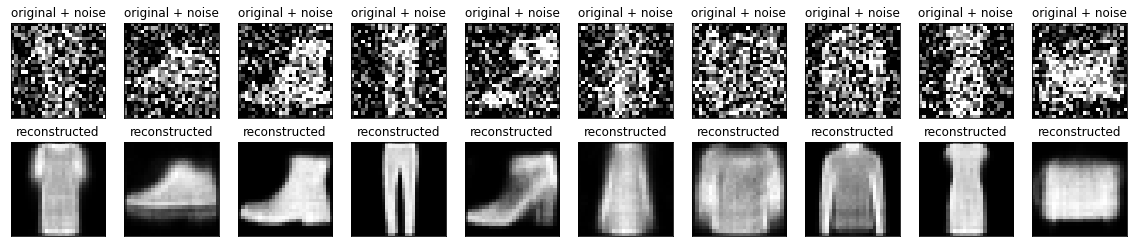

In [7]:
predictions = autoencoder.predict(noisyTestSet)
showImgArrays(noisyTestSet, predictions, 10, txt1="original + noise")

In [ ]:
# Save the model
autoencoder.save("modelAutoencoderNoisy.h5")